Как водится в продакшен-реди решениях на тензорфлоу надо перезапустить среду каждый раз после установки нового пакета - это не ошибка.

In [ ]:
#!pip install --upgrade numpy tensorflow

## **Load the required libraries**

In [ ]:
#!pip install sionna

In [ ]:
# You may install the required libraries from https://nvlabs.github.io/sionna/installation.html
# or generate channel here in google colab
# ---------------------------------------------------------------------------------------------
# Load the required libraries
import numpy as np
import matplotlib.pyplot as plt

try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
from sionna.phy.channel.tr38901 import Antenna, AntennaArray, UMa, UMi, RMa
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, gen_single_sector_topology
from sionna.phy.ofdm import ResourceGrid

## **Configiration parameters**

In [ ]:
# ===========================
# 1️⃣ Define BS & UE Parameters
# ===========================
num_bs = 1  # Number of Base Stations
num_ue = 20  # Number of User Equipments   уменьшила до 20
num_ue_ant = 4  # UE MIMO Antennas
batch_size = 40  # Number of parallel simulations   уменьшила до 4
scenario = "UMa"  # Urban Macro (Can be "UMa", "UMi", "RMa")
min_bs_ut_dist = 100 # Minimum BS-UE distance in meters
ISD = 500 # Inter-Site Distance
bs_height = 25 # BS height in meters
ut_height = 1.5 # UE height in meters
UE_speed = 0.83 # UE speed in meters/second

# ===========================
# 2️⃣ Define Resource Grid
# ===========================
carrier_frequency = 3.5e9  # 2.14 or 3.5 GHz (mid-band 5G)
fft_size = 256  # FFT Size   уменьшила до 256
sc_spacing = 30e3  # Subcarrier Spacing (30 kHz for FR1)
num_ofdm_symbols = 1  # OFDM symbols per slot

# ===========================
# 3️⃣ Define Antenna Array Configurations
# ===========================
bs_array = AntennaArray(
    num_rows=4, # number of rows in BS antenna array
    num_cols=8, # number of columns in BS antenna array
    polarization="dual", # "single" or "dual"
    polarization_type="cross", # for single polarization, must be "V" or "H". For dual polarization, must be "VH" or "cross"
    antenna_pattern="38.901", # "omni" or "38.901"
    carrier_frequency=carrier_frequency,
    vertical_spacing=0.9, # 0.9-wavelength spacing between vertical antenna elements
    horizontal_spacing=0.5 # Half-wavelength spacing between horizontal antenna elements
)

ue_array = AntennaArray(
    num_rows=1, # number of rows in UE antenna array
    num_cols=2, # number of columns in UE antenna array
    polarization="dual", # "single" or "dual"
    polarization_type="cross", # for single polarization, must be "V" or "H". For dual polarization, must be "VH" or "cross"
    antenna_pattern="38.901", # "omni" or "38.901"
    carrier_frequency=carrier_frequency,
    vertical_spacing=1, # One-wavelength spacing between vertical antenna elements
    horizontal_spacing=1  # One-wavelength spacing between horizontal antenna elements
)

# ===========================
# 4️⃣ Select Channel Model
# ===========================
if scenario == "UMa":
  channel_model = UMa(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")
elif scenario == "UMi":
  channel_model = UMi(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")
elif scenario == "RMa":
  channel_model = RMa(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")

# ===========================
# 5️⃣ Set 3GPP Scenario Parameters
# ===========================
pre_topology = sionna.phy.channel.set_3gpp_scenario_parameters(
                      scenario=scenario.lower(),
                      min_bs_ut_dist=min_bs_ut_dist,  # Minimum BS-UE distance in meters
                      isd=ISD,  # Inter-Site Distance
                      bs_height=bs_height,  # BS height in meters
                      min_ut_height=ut_height,  # Minimum UE height in meters
                      max_ut_height=ut_height,  # Maximum UE height in meters
                      indoor_probability=0, # Probability of a UE to be indoor
                      min_ut_velocity=UE_speed, # ! meter/sec
                      max_ut_velocity=UE_speed)

min_bs_ut_dist, isd, bs_height, min_ut_height, max_ut_height, indoor_probability, min_ut_velocity, max_ut_velocity = pre_topology

## **Channel generation**

In [ ]:
# ===========================
# 6️⃣ Generate Single Sector Topology
# ===========================
topology = gen_single_sector_topology(
                      batch_size=batch_size,
                      num_ut=num_ue,
                      isd=isd,
                      min_bs_ut_dist=min_bs_ut_dist,
                      scenario=scenario.lower(),
                      min_ut_height=min_ut_height,
                      max_ut_height=max_ut_height,
                      indoor_probability=indoor_probability,
                      min_ut_velocity=min_ut_velocity,
                      max_ut_velocity=max_ut_velocity)

ut_loc, bs_loc, ut_orientations, bs_orientations, ut_velocities, in_state = topology

# ===========================
# 7️⃣ Set Topology into the Channel Model
# ===========================
channel_model.set_topology(
    ut_loc,
    bs_loc,
    ut_orientations,
    bs_orientations,
    ut_velocities,
    in_state,
    los = False)# los=False=NLoS, los=True=LoS, None=LoS

channel_model.show_topology()

# ===========================
# 8️⃣ Simulate Time-Domain Channel
# ===========================
a, tau = channel_model(num_time_samples=num_ofdm_symbols,sampling_frequency=sc_spacing)  # Get channel impulse response (CIR)

# ===========================
# 9️⃣ Move Channel from Time to Frequency Domain
# ===========================
subcarrier_freqs = subcarrier_frequencies(fft_size, sc_spacing)
H_freq = cir_to_ofdm_channel(subcarrier_freqs, a, tau, normalize=True)  # Convert CIR to OFDM channel

print("-----------------------------------------------------")
print(f"Size of output frequency domain channel tensor:\n batch_size = {H_freq.shape[0]} \n UE number = {H_freq.shape[1]} \n UE antenna number = {H_freq.shape[2]} \n BS number = {H_freq.shape[3]} \n BS antenna number = {H_freq.shape[4]} \n number ofdm symbols = {H_freq.shape[5]} \n Subcarriers number = {H_freq.shape[6]}")
print("*********** Successful channel generation ***********")

# ===========================
# ✅ Output Results
# ===========================
H_freq = np.transpose(np.squeeze(H_freq),(3,2,4,1,0)) # Output channel tensor H=[N_tx x N_rx x N_sc x N_ue x N_batch]

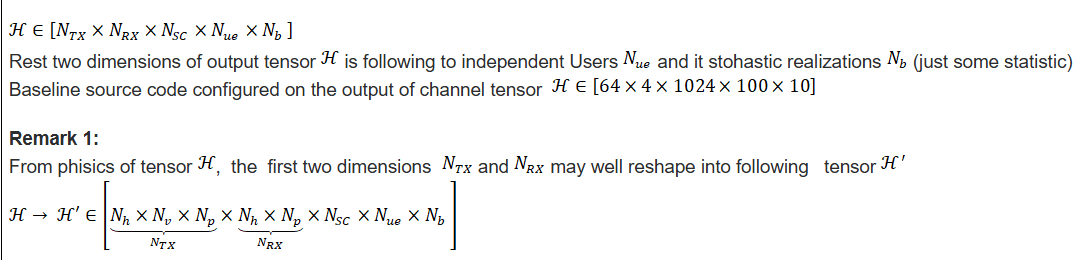

## **Save the channel tensor to '.mat' or '.npy' file**

In [ ]:
# from scipy.io import savemat
# savemat(f"Sionna_3GPP_{scenario.upper()}_Channel.mat", {'Hfrq': H_freq})
# from google.colab import files
# files.download(f"Sionna_3GPP_{scenario.upper()}_Channel.mat") # uncomment this to download the tensor

Разложение Такера

In [ ]:
!pip install tensorly

In [ ]:
import tensorly as tl
from tensorly.decomposition import tucker
import numpy as np

In [ ]:
tl.set_backend('numpy')

In [ ]:
def decompose_tensor(original_tensor, rank):
    """
    Decomposes a complex-valued tensor using Tucker decomposition.

    Args:
        original_tensor (ndarray): Complex tensor of shape (64, 4, 1024)
        rank (tuple): Target rank for each dimension, e.g., (32, 4, 128)

    Returns:
        core (ndarray): The core tensor of shape = rank
        factors (list): List of factor matrices [U1, U2, U3]
    """
    # Ensure we're working with the selected backend
    original_tensor = tl.tensor(original_tensor)

    # Perform Tucker decomposition
    core, factors = tucker(original_tensor, rank=rank)

    return core, factors

def reconstruct_tensor(core, factors):
    """
    Reconstructs the original tensor from the Tucker decomposition components.

    Args:
        core (ndarray): The core tensor
        factors (list): List of factor matrices

    Returns:
        reconstructed_tensor (ndarray): Tensor of original shape (64, 4, 1024)
    """
    # Reconstruct by multiplying core with factor matrices
    reconstructed_tensor = tl.tucker_to_tensor((core, factors))

    return reconstructed_tensor

In [ ]:
target_rank = (32, 4, 128)

In [ ]:
H_freq_tucker = np.zeros(target_rank+(H_freq.shape[-2],)+(H_freq.shape[-1],),dtype=np.complex64)

In [ ]:
core, factors = decompose_tensor(H_freq[:,:,:,0,0], target_rank)

In [ ]:
avg_factors = [np.zeros_like(f) for f in factors]

In [ ]:
n_batch = H_freq.shape[-1]

In [ ]:
n_user = H_freq.shape[-2]

In [ ]:
n_total = n_batch*n_user

In [68]:
for batch in range(n_batch):
  for user in range(n_user):
    core, factors = decompose_tensor(H_freq[:,:,:,user,batch], target_rank)
    for i,f in enumerate(factors):
      avg_factors[i]+=1/n_total*f
    H_freq_tucker[:,:,:,user,batch]=core

In [69]:
H_freq.shape

(64, 4, 256, 20, 40)

In [70]:
H_freq_tucker.shape

(32, 4, 128, 20, 40)

Как возвращать тензор в исходное состояние

In [71]:
#tuk = H_freq_tucker[:,:,:,0,0]#допустим, сгенерировалось такое

In [72]:
#untuck = reconstruct_tensor(tuk, avg_factors)#восстанавливаем с помощью осреднённых сомножителей (для этой операции при неосреднённых сомножителях ответ H_freq[:,:,:,0,0])

In [73]:
#np.sqrt(np.abs(np.mean((untuck - H_freq[:,:,:,0,0])**2)))/np.max(np.abs(H_freq[:,:,:,0,0]))#ошибка в 2.3% в среднем

In [74]:
#разделене на действительную и мнимую части
H_freq_real = np.real(H_freq_tucker)
H_freq_imag = np.imag(H_freq_tucker)

In [75]:
print(H_freq_real.shape)
print(H_freq_imag.shape)

(32, 4, 128, 20, 40)
(32, 4, 128, 20, 40)


In [76]:
H_combined = np.stack([H_freq_real, H_freq_imag], axis=-1)
H_combined.shape  # (N_tx, N_rx, N_subcarriers, N_users, N_batches, real/img)  or [BS antenna number,  UE antenna number, Subcarriers number, UE number, batch_size, real/img]

(32, 4, 128, 20, 40, 2)

N_tx (BS antenna number) - Количество антенн на Базовой Станции, 32 после Такера

N_rx (UE antenna number) - Количество антенн на Пользовательском Устройстве, 4

N_subcarriers (Subcarriers number) - Количество поднесущих, 128 после Такера

N_users (UE number) - Количество пользователей, 20

N_batches (batch_size) - Количество батчей, 4

каждое число имеет вид H[i,j,k,l,m] = a + bj = |H| * e^(jφ),где

|H| (амплитуда) - ослабление сигнала на этой поднесущей

φ (фаза) - фазовый сдвиг сигнала

i - какая антенна BS передает

j - какая антенна UE принимает

k - на какой поднесущей частоте

l - для какого пользователя

m - в какой реализации канала

In [77]:
#меняем местами для диффузии, батчи надо сгрупировать
H_flat = H_combined.transpose(4, 3, 0, 1, 2, 5) #(4, 20, 32, 4, 128, 2) т.е. [batch_size, UE number, BS antenna number, UE antenna number, Subcarriers number, real/img]
H_flat.shape

(40, 20, 32, 4, 128, 2)

In [78]:
#80 семплов, 32 и 4 колво антенн, 128 - колво поднесущих (частотная характеристика)
H_flat = H_flat.reshape(-1, 32, 4, 128, 2)
H_flat.shape

(800, 32, 4, 128, 2)

In [79]:
amplitude = np.abs(H_flat)
print(amplitude.min())
print(amplitude.max())
print(amplitude.std()) # -> лучше сделать нормализацию

0.0
235.21918
1.4109013


In [80]:
from sklearn.preprocessing import StandardScaler

original_shape = H_flat.shape

data_flat = H_flat.reshape(original_shape[0], -1)
scaler = StandardScaler()
scaler.fit(data_flat)

data_normalized = scaler.transform(data_flat)
data_normalized = data_normalized.reshape(original_shape)  # shape: (80, 32, 4, 128, 2)

print(f"Normalized data range: [{data_normalized.min():.3f}, {data_normalized.max():.3f}]")

Normalized data range: [-28.107, 28.026]


In [81]:
#!pip install denoising-diffusion-pytorch --upgrade

In [82]:
#!pip install diffusers transformers accelerate torch torchvision

In [83]:
import huggingface_hub
print(huggingface_hub.__version__)

0.34.4


In [84]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
# Конвертируем в тензоры PyTorch
data_tensor = torch.FloatTensor(data_normalized)  # shape: (80, 32, 4, 128, 2)

# Переупорядочиваем измерения для модели: [batch, channels, depth, height, width]
data_tensor = data_tensor.permute(0, 4, 3, 1, 2)  # shape: (80, 2, 128, 32, 4)

# Создаем Dataset и DataLoader
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

print(f"DataLoader ready with {len(dataloader)} batches")

DataLoader ready with 100 batches


библиотечные UNet3DConditionModel для видео и диффузия с двумя каналами не работают, поэтому делаем кастомные Unet и диффузию

In [ ]:
class CustomUnet3D(nn.Module):
    def __init__(self, in_channels=2, base_dim=64):
        super().__init__()

        # Embedding для временных шагов
        self.time_embedding = nn.Sequential(
            nn.Linear(1, base_dim),
            nn.ReLU(),
            nn.Linear(base_dim, base_dim)
        )

        self.network = nn.Sequential(
            # Block 1
            nn.Conv3d(in_channels, base_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(base_dim, base_dim, 3, padding=1),
            nn.ReLU(),

            # Block 2
            nn.Conv3d(base_dim, base_dim * 2, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(base_dim * 2, base_dim * 2, 3, padding=1),
            nn.ReLU(),

            # Block 3
            nn.Conv3d(base_dim * 2, base_dim * 4, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(base_dim * 4, base_dim * 4, 3, padding=1),
            nn.ReLU(),

            # Block 4
            nn.Conv3d(base_dim * 4, base_dim * 2, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(base_dim * 2, base_dim * 2, 3, padding=1),
            nn.ReLU(),

            # Block 5
            nn.Conv3d(base_dim * 2, base_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(base_dim, base_dim, 3, padding=1),
            nn.ReLU(),

            # Final layer
            nn.Conv3d(base_dim, in_channels, 3, padding=1)
        )

    def forward(self, x, timesteps=None):
        # Если переданы временные шаги, добавляем embedding
        if timesteps is not None:
            # Преобразуем timesteps в embedding и добавляем к данным
            time_emb = self.time_embedding(timesteps.float().unsqueeze(1))
            # Нужно broadcast time_emb к размеру x
            # Это сложнее для 3D данных, можно пропустить если не критично
            pass

        return self.network(x)

In [ ]:
from diffusers import DDPMScheduler
from torch.optim import Adam
from tqdm import tqdm
import torch.nn as nn

model = CustomUnet3D(in_channels=2)

# Настройки обучения
num_epochs = 100
lr = 1e-4

# Шумовой scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear",
    prediction_type="epsilon"
)

optimizer = Adam(model.parameters(), lr=lr)

# Обучение
model.train()
model

for epoch in range(num_epochs):
    total_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Извлекаем тензор из списка (DataLoader возвращает [tensor])
        batch = batch[0]  # <-- ИСПРАВЛЕНИЕ ЗДЕСЬ

        # Генерируем шум
        noise = torch.randn_like(batch)

        # Выбираем случайные временные шаги
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (batch.shape[0],)  # <-- Добавлен device
        ).long()

        # Добавляем шум
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)

        # Предсказываем шум
        noise_pred = model(noisy, timesteps)

        # Вычисляем loss
        loss = nn.functional.mse_loss(noise_pred, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

In [ ]:
from diffusers import DDPMPipeline

# Создаем pipeline для генерации
pipeline = DDPMPipeline(
    unet=model,
    scheduler=noise_scheduler
)

# Генерируем новые данные
num_samples = 10  # Сколько новых samples сгенерировать
generated_data = pipeline(batch_size=num_samples).images

# generated_data shape: [num_samples, 2, 32, 4, 128]

In [ ]:
def reconstruct_full_channel(generated_data, dataset):
    """
    Восстанавливает полные канальные данные из сгенерированного тензора
    """
    # 1. Обратная нормализация
    generated_np = generated_data.cpu().numpy()
    original_shape = generated_np.shape  # [batch, 2, 32, 4, 128]

    # Меняем порядок измерений обратно
    generated_np = generated_np.transpose(0, 2, 3, 4, 1)  # [batch, 32, 4, 128, 2]

    # Применяем обратное преобразование нормализации
    flat_data = generated_np.reshape(original_shape[0], -1)
    denormalized = dataset.scaler.inverse_transform(flat_data)
    denormalized = denormalized.reshape(original_shape[0], 32, 4, 128, 2)

    # 2. Объединяем real и imag части
    real_part = denormalized[..., 0]
    imag_part = denormalized[..., 1]
    complex_data = real_part + 1j * imag_part

    return complex_data

# Реконструируем сгенерированные данные
generated_complex = reconstruct_full_channel(generated_data, dataset)

In [ ]:
def validate_generated_data(original, generated):
    """
    Сравнивает статистические характеристики оригинальных и сгенерированных данных
    """
    # Статистики амплитуд
    orig_amplitude = np.abs(original)
    gen_amplitude = np.abs(generated)

    # Статистики фазы
    orig_phase = np.angle(original)
    gen_phase = np.angle(generated)

    print("Амплитуда:")
    print(f"Оригинал - Mean: {orig_amplitude.mean():.3f}, Std: {orig_amplitude.std():.3f}")
    print(f"Сгенерировано - Mean: {gen_amplitude.mean():.3f}, Std: {gen_amplitude.std():.3f}")

    print("\nФаза:")
    print(f"Оригинал - Mean: {orig_phase.mean():.3f}, Std: {orig_phase.std():.3f}")
    print(f"Сгенерировано - Mean: {gen_phase.mean():.3f}, Std: {gen_phase.std():.3f}")

    # Корреляция между измерениями
    print(f"\nКорреляция амплитуд: {np.corrcoef(orig_amplitude.flatten(), gen_amplitude.flatten())[0,1]:.3f}")

# Берем оригинальные данные для сравнения
original_samples = dataset.data[:num_samples].cpu().numpy()
original_samples = original_samples.transpose(0, 2, 3, 4, 1)  # [batch, 32, 4, 128, 2]
original_real = original_samples[..., 0]
original_imag = original_samples[..., 1]
original_complex = original_real + 1j * original_imag

validate_generated_data(original_complex, generated_complex)

In [ ]:
# Сохраняем модель
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler': dataset.scaler,
}, 'channel_diffusion_model.pth')

# Загрузка для последующего использования
checkpoint = torch.load('channel_diffusion_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
scaler = checkpoint['scaler']

In [ ]:
#pip install torchcfm --upgrade


In [ ]:
#pip install "scipy==1.10.1"

In [ ]:
import scipy, ot
print('SciPy:', scipy.__version__); print('POT:', ot.__version__)

In [85]:
import torch
import torch.nn as nn

class TimeCondUnet3D(nn.Module):
    def __init__(self, in_channels=2, base_dim=64):
        super().__init__()
        c_in = in_channels + 1  # +1 канал под t

        self.net = nn.Sequential(
            nn.Conv3d(c_in, base_dim, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim, base_dim, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim, base_dim*2, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim*2, base_dim*2, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim*2, base_dim*4, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim*4, base_dim*4, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim*4, base_dim*2, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim*2, base_dim*2, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim*2, base_dim, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim, base_dim, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim, in_channels, 3, padding=1)
        )

    def forward(self, x, t):
        # x: [B, 2, 128, 32, 4]; t: [B] или [B,1] в [0,1]
        B, C, D, H, W = x.shape
        if t.ndim == 1:
            t = t[:, None]
        t_map = t.view(B, 1, 1, 1, 1).expand(B, 1, D, H, W)
        x_in = torch.cat([x, t_map], dim=1)
        return self.net(x_in)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np

try:
    data_tensor
except NameError:
    data_tensor = torch.from_numpy(data_normalized).float().permute(0, 4, 3, 1, 2)  # [N,2,128,32,4]

dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

model = TimeCondUnet3D(in_channels=2, base_dim=64).to(device)

# SB-CFM
try:
    from torchcfm.conditional_flow_matching import SchrodingerBridgeConditionalFlowMatcher
except Exception:
    from torchcfm.losses import SchrodingerBridgeConditionalFlowMatcher

cfm = SchrodingerBridgeConditionalFlowMatcher(sigma=0.5, ot_method="exact")
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

def _cfm_call_and_reshape(cfm, x0, x1, t):
    """
    x0, x1: [B, 2, 128, 32, 4] -> flatten -> cfm -> reshape back
    Возвращает xt, ut той же формы, что x1.
    """
    B = x1.shape[0]
    x0_flat = x0.view(B, -1)
    x1_flat = x1.view(B, -1)

    try:
        out = cfm.sample_location_and_conditional_flow(x0_flat, x1_flat, t)
    except AttributeError:
        out = cfm(x0_flat, x1_flat, t)

    if isinstance(out, dict):
        xt_flat = out.get("xt", None)
        ut_flat = out.get("ut", None)
        if xt_flat is None or ut_flat is None:
            # find two tensors of (B, D) shape
            candidates = [v for v in out.values()
                          if torch.is_tensor(v) and v.dim() == 2 and v.shape[0] == B]
            assert len(candidates) >= 2, "CFM dict does not contain (xt, ut)"
            xt_flat, ut_flat = candidates[0], candidates[1]
    else:
        # sequence: find two tensors of (B, D) shape
        seq = list(out) if isinstance(out, (tuple, list)) else [out]
        candidates = [v for v in seq
                      if torch.is_tensor(v) and v.dim() == 2 and v.shape[0] == B]
        assert len(candidates) >= 2, "CFM output does not contain two tensors (B, D)"
        xt_flat, ut_flat = candidates[0], candidates[1]

    # Inverse reshape to [B, 2, 128, 32, 4]
    xt = xt_flat.view_as(x1)
    ut = ut_flat.view_as(x1)
    return xt, ut


In [88]:
num_epochs = 100
model.train()
for epoch in range(num_epochs):
    total = 0.0
    for (x1_batch,) in tqdm(dataloader, desc=f"SB-CFM epoch {epoch+1}/{num_epochs}"):
        x1 = x1_batch.to(device)                     # [B, 2, 128, 32, 4]
        x0 = torch.randn_like(x1)                    # [B, 2, 128, 32, 4]
        t  = torch.rand(x1.size(0), device=device)   # [B], U(0,1)

        # (x_t, u_t) of input's shape
        xt, ut = _cfm_call_and_reshape(cfm, x0, x1, t)
        xt, ut = xt.to(device), ut.to(device)

        pred = model(xt, t)

        loss = nn.functional.mse_loss(pred, ut)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item()

    print(f"Epoch {epoch+1}: loss={total/len(dataloader):.4f}")

SB-CFM epoch 1/100: 100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


Epoch 1: loss=2.8477


SB-CFM epoch 2/100: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


Epoch 2: loss=2.7959


SB-CFM epoch 3/100: 100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


Epoch 3: loss=4.2251


SB-CFM epoch 4/100: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


Epoch 4: loss=2.4018


SB-CFM epoch 5/100: 100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


Epoch 5: loss=2.4045


SB-CFM epoch 6/100: 100%|██████████| 100/100 [00:29<00:00,  3.45it/s]


Epoch 6: loss=3.5369


SB-CFM epoch 7/100: 100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


Epoch 7: loss=2.7592


SB-CFM epoch 8/100: 100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


Epoch 8: loss=2.3116


SB-CFM epoch 9/100: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


Epoch 9: loss=4.1483


SB-CFM epoch 10/100: 100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


Epoch 10: loss=2.5421


SB-CFM epoch 11/100: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


Epoch 11: loss=2.3114


SB-CFM epoch 12/100: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


Epoch 12: loss=2.2013


SB-CFM epoch 13/100: 100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


Epoch 13: loss=2.4738


SB-CFM epoch 14/100: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


Epoch 14: loss=4.1139


SB-CFM epoch 15/100: 100%|██████████| 100/100 [00:29<00:00,  3.34it/s]


Epoch 15: loss=4.0341


SB-CFM epoch 16/100: 100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


Epoch 16: loss=2.3726


SB-CFM epoch 17/100: 100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


Epoch 17: loss=3.3155


SB-CFM epoch 18/100: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


Epoch 18: loss=2.1711


SB-CFM epoch 19/100: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


Epoch 19: loss=2.3042


SB-CFM epoch 20/100:  16%|█▌        | 16/100 [00:04<00:26,  3.22it/s]


KeyboardInterrupt: 

In [91]:
@torch.no_grad()
def sample_sb_sde(model, num_samples=10, steps=40, shape=(2, 128, 32, 4),
                  sde_sigma=0.2, schedule="const"):
    """
    x_{k+1} = x_k + dt * v_theta(x_k, t_k) + g(t_k) * sqrt(dt) * N(0,I)
    """
    model.eval()
    x = torch.randn((num_samples,) + shape, device=device)
    dt = 1.0 / steps

    def g_of_t(t_scalar):
        if schedule == "const":
            return sde_sigma
        elif schedule == "vp":
            return sde_sigma * float(np.cos(0.5*np.pi*float(t_scalar)))
        else:
            return sde_sigma

    for k in range(steps):
        t = torch.full((num_samples,), (k + 0.5) / steps, device=device)
        v = model(x, t)
        g = g_of_t((k + 0.5) / steps)
        x = x + dt * v + (g * np.sqrt(dt)) * torch.randn_like(x)
    return x  # [N, 2, 128, 32, 4]

gen_2c = sample_sb_sde(model, num_samples=10, steps=40, shape=(2,128,32,4), sde_sigma=0.2)

def inverse_normalize_to_complex(samples_2c, scaler):
    """
    samples_2c: [N, 2, 128, 32, 4] (torch.Tensor)
    -> complex np.ndarray [N, 32, 4, 128]
    """
    x = samples_2c.detach().cpu().numpy()
    x = x.transpose(0, 2, 3, 4, 1)  # [N,128,32,4,2]
    x = x.transpose(0, 2, 3, 1, 4)  # [N,32,4,128,2]
    flat = x.reshape(x.shape[0], -1)
    denorm = scaler.inverse_transform(flat).reshape(x.shape)
    real = denorm[..., 0]
    imag = denorm[..., 1]
    return real + 1j*imag

generated_complex = inverse_normalize_to_complex(gen_2c, scaler)

# Metrics
orig_2c = data_tensor[:generated_complex.shape[0]]
original_complex = inverse_normalize_to_complex(orig_2c, scaler)
validate_generated_data(original_complex, generated_complex)


Амплитуда:
Оригинал - Mean: 0.127, Std: 1.996
Сгенерировано - Mean: 0.177, Std: 1.969

Фаза:
Оригинал - Mean: -0.003, Std: 1.815
Сгенерировано - Mean: -0.008, Std: 1.818

Корреляция амплитуд: 0.561
